In [1]:
import scipy as sp
import numpy as np
import pandas as pd
import timeit
import re
import json
import pickle
import fastparquet
import os
os.chdir('/mnt/t48/bighomes-active/sfeng/patentdiffusion/')
seed = 3
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
import datetime
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.iolib.summary2 as summary2

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


- Code taken from: https://sfengc7.stern.nyu.edu:8888/notebooks/patentdiffusion/201804KnowledgeSpilloversRep/3b-RegCoefficients-0508.ipynb

In [2]:
pathdir = "DataStore/2018-10/Reg0930/"
reg_f = "reg_model_1002.pkl"

regs = pickle.load(open(pathdir+reg_f, "rb"))

# Model names to equations
regs["model_names_eqn"] = dict(zip(regs["model_names"].tolist(), regs["model_names"].index.tolist()))

In [59]:
# JTH Rep
jr = pd.read_csv("DataStore/2018-07-P3/JTHReg0727/JTH_res_out_0726.csv",index_col=0)
jr.loc[jr["index"] == "$I(MSA \, Match)$", "index"] = "C(inv_msa_match)[T.True]"

# FE results (0930 - uses full dataset) and Sim results (1003 - uses only those with sim pc, sim pc msa values)
rr = pd.read_csv("DataStore/2018-10/Reg0930/reg_pairs_out_0930.csv",index_col=0)
rr2 = pd.read_csv("DataStore/2018-10/Reg0930/reg_pairs_out_1003.csv",index_col=0)
rr = rr.loc[~rr["Model"].isin(rr2["Model"])].append(rr2, ignore_index=True)

# Use reg_model_1002 to assign model numbers
rr["Model Num"] = rr["Model"].map(regs["model_names_eqn"])

# Get rid of models without a number (squared ones excluded from analysis)
print(len(rr))
rr = rr.loc[rr["Model Num"].notnull()]
print(len(rr))
rr["samp"] = rr["samp"].apply(eval)
rr = pd.concat([jr,rr],axis=0)
# Reset index
rr = rr.reset_index(drop=True)
# Integer model number
rr["Model Num"] = rr["Model Num"].astype(int)
# Equation id
rr["id"] = ["({0}, {1}, {2})".format(i,j,k) for i,j,k in zip(rr["samp"], rr["LKS"], rr["Model"])]
rr["id"] = rr["id"].astype(str)

# Add S.E.
# S.E. index
se_ind = rr.loc[rr["index"].isnull()].index.tolist()

for ind in se_ind:
    rr.loc[ind, "index"] = "SE {0}".format(rr.loc[ind-1, "index"])

5122
1492


In [120]:
# Regression models
# Primclass
rm_pc = [
    # JTH norm percentage match PC FE
    "(JTH Rep, norm_perc_match_10, N Perc Match Targ MSA, PC FE)",
    # pcc N PC FE
#     "(('tp_pct_common_cited', 'primclass'), norm_tp_pct_common_cited, N PC FE)",
    # docvecs N PC FE
    "(('docvecs', 'primclass'), norm_sim_docvecs, N PC FE)",
    # sim pc MSA N All FE
    "(('docvecs', 'primclass'), norm_sim_docvecs, N Inv FE-Sim PC MSA)"    
]

# rm_pc_n = ["Citations Benchmark", "Pct Common Cited Pats", "Sim DocVecs, PC FE", "Sim DocVecs, Sim PC MSA"]
rm_pc_n = ["Citations Benchmark", "Sim DocVecs, PC FE", "Sim DocVecs, Sim PC MSA"]

# NAICS
rm_n = [
    # JTH norm percentage match PC FE
    "(JTH Rep, norm_perc_match_10, N Perc Match Targ MSA, PC FE)",
    # pcc N PC FE
#     "(('tp_pct_common_cited', 'naics_name'), norm_tp_pct_common_cited, N PC FE)",
    # docvecs N PC FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC FE)",
    # sim pc N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N All FE-Sim PC)",
    # sim pc MSA N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N All FE-Sim PC MSA)"    
]

# rm_n_n = ["Citations Benchmark", "Pct Common Cited Pats", "Sim DocVecs, PC FE", "Sim DocVecs, Sim PC", "Sim DocVecs, Sim PC MSA"]
rm_n_n = ["Citations Benchmark", "Sim DocVecs, PC FE", "Sim DocVecs, Sim PC", "Sim DocVecs, Sim PC MSA"]

rm_d = dict(zip(rm_pc, rm_pc_n))
rm_d.update(dict(zip(rm_n, rm_n_n)))


### Primclass sample

In [121]:
# Localization estimates
rc = rr.loc[rr["id"].isin(rm_pc) & rr["index"].isin(["C(inv_msa_match)[T.True]", "SE C(inv_msa_match)[T.True]"])]

# Strip punctuation
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[:6]))

rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[1:7]))

# New id
rc["id"] = rc["id"].map(rm_d)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [122]:
# Reshape long
rcl = pd.DataFrame()
for ind in rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]")].index:
    r2 = pd.DataFrame()
    r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
    r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
    se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
    r2["Err Bar"] = se*1.96
    r2["id"] = rc.loc[ind, "id"]
    rcl = rcl.append(r2, ignore_index=True)

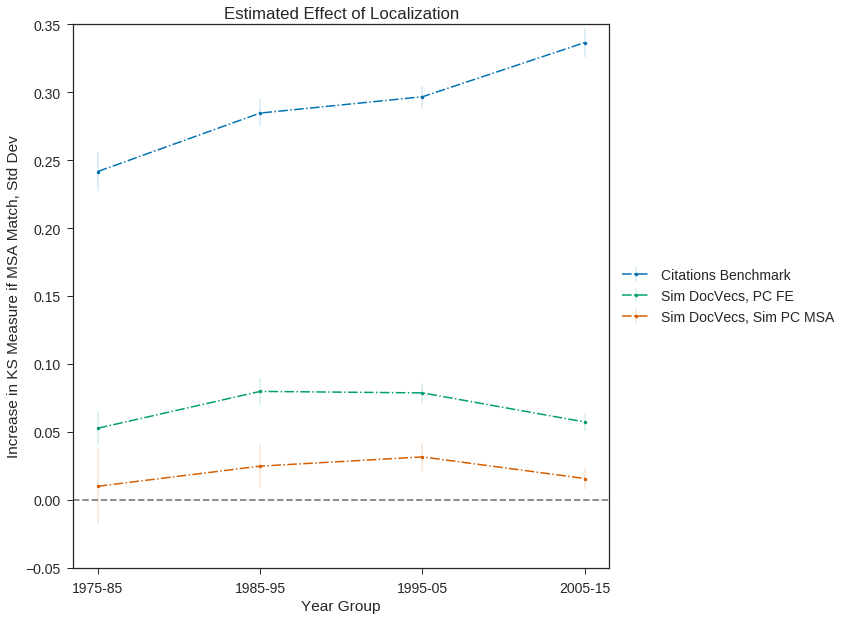

In [123]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-muted')

d2 = rcl.groupby("id")
spal = sns.color_palette("colorblind", 10).as_hex()
# spal = sns.choose_colorbrewer_palette("qualitative")
# spal = sns.color_palette("Paired", 4).as_hex()
cpal = dict(zip(d2.groups.keys(),spal))
key_order = list(d2.groups.keys())
x_col = "Year Group"
y_col = "Local Est"
y_err="Err Bar"
y_min = -0.05
y_max = 0.35

fig, ax = plt.subplots(figsize=(12,10))
for n in key_order:
    ax.errorbar(x = x_col, y = y_col, yerr = y_err, errorevery=1, fmt=".-", ls="-.",
                elinewidth = 0.25, 
                    linewidth = 1.5, color = cpal[n], label = n, data = d2.get_group(n).copy())
    
# Horizontal line
ax.axhline(y=0, color='grey', linestyle='--')

ax.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Estimated Effect of Localization")

ax.set_xlabel(x_col)
ax.set_ylabel("Increase in KS Measure if MSA Match, Std Dev")
ax.set_ylim(y_min, y_max)

plt.savefig("DataStore/2018-10/ResultsGraphs/pc_local_est.png")
plt.show()

### NAICS Sample

In [124]:
# Localization estimates
rc = rr.loc[rr["id"].isin(rm_n) & rr["index"].isin(["C(inv_msa_match)[T.True]", "SE C(inv_msa_match)[T.True]"])]

# Strip punctuation
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[:6]))

rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[1:7]))

# New id
rc["id"] = rc["id"].map(rm_d)

# Reshape long
rcl = pd.DataFrame()
for ind in rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]")].index:
    r2 = pd.DataFrame()
    r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
    r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
    se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
    r2["Err Bar"] = se*1.96
    r2["id"] = rc.loc[ind, "id"]
    rcl = rcl.append(r2, ignore_index=True)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [125]:
# Reshape long
rcl = pd.DataFrame()
for ind in rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]")].index:
    r2 = pd.DataFrame()
    r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
    r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
    se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
    r2["Err Bar"] = se*1.96
    r2["id"] = rc.loc[ind, "id"]
    rcl = rcl.append(r2, ignore_index=True)

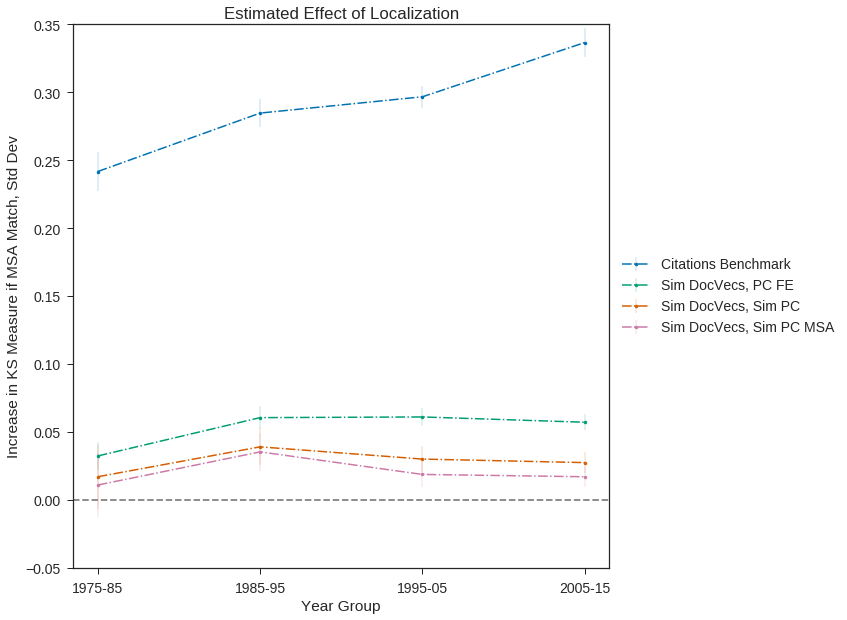

In [126]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-muted')

d2 = rcl.groupby("id")
spal = sns.color_palette("colorblind", 10).as_hex()
# spal = sns.choose_colorbrewer_palette("qualitative")
# spal = sns.color_palette("Paired", 4).as_hex()
cpal = dict(zip(d2.groups.keys(),spal))
key_order = list(d2.groups.keys())
x_col = "Year Group"
y_col = "Local Est"
y_err="Err Bar"
y_min = -0.05
y_max = 0.35

fig, ax = plt.subplots(figsize=(12,10))
for n in key_order:
    ax.errorbar(x = x_col, y = y_col, yerr = y_err, errorevery=1, fmt=".-", ls="-.",
                elinewidth = 0.25, 
                    linewidth = 1.5, color = cpal[n], label = n, data = d2.get_group(n).copy())
    
# Horizontal line
ax.axhline(y=0, color='grey', linestyle='--')

ax.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_title("Estimated Effect of Localization")

ax.set_xlabel(x_col)
ax.set_ylabel("Increase in KS Measure if MSA Match, Std Dev")
ax.set_ylim(y_min, y_max)

plt.savefig("DataStore/2018-10/ResultsGraphs/naics_local_est.png")
plt.show()

### Other match variables

In [130]:
# Regression models
# NAICS
rm_n = [
    # docvecs N PC FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC FE)",
    # sim pc N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N Inv M-PC FE)",
    # sim pc MSA N All FE
    "(('docvecs', 'naics_name'), norm_sim_docvecs, N PC M-PC FE)"    
]

# rm_n_n = ["Citations Benchmark", "Pct Common Cited Pats", "Sim DocVecs, PC FE", "Sim DocVecs, Sim PC", "Sim DocVecs, Sim PC MSA"]
rm_n_n = ["MSA Match", "Inventor Match", "Primclass Match"]

rm_d = dict(zip(rm_pc, rm_pc_n))
rm_d.update(dict(zip(rm_n, rm_n_n)))

In [135]:
# Match estimates
rc = rr.loc[rr["id"].isin(rm_n)]

# Replace all match variables
rc["index"] = rc["index"].apply(lambda x: x.replace("common_pat_inv", "inv_msa_match")\
.replace("primclass_match", "inv_msa_match"))

# Strip punctuation
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[:6]))

rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]] = \
rc.loc[(rc["index"] == "SE C(inv_msa_match)[T.True]"), ["1975-85", "1985-95", "1995-05", "2005-15"]].applymap(\
    lambda s: float(s[1:7]))

# New id
rc["id"] = rc["id"].map(rm_d)

# Reshape long
rcl = pd.DataFrame()
for ind in rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]")].index:
    r2 = pd.DataFrame()
    r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
    r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
    se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
    r2["Err Bar"] = se*1.96
    r2["id"] = rc.loc[ind, "id"]
    rcl = rcl.append(r2, ignore_index=True)

/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/homedir/eco/sfeng/bigdata/python/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

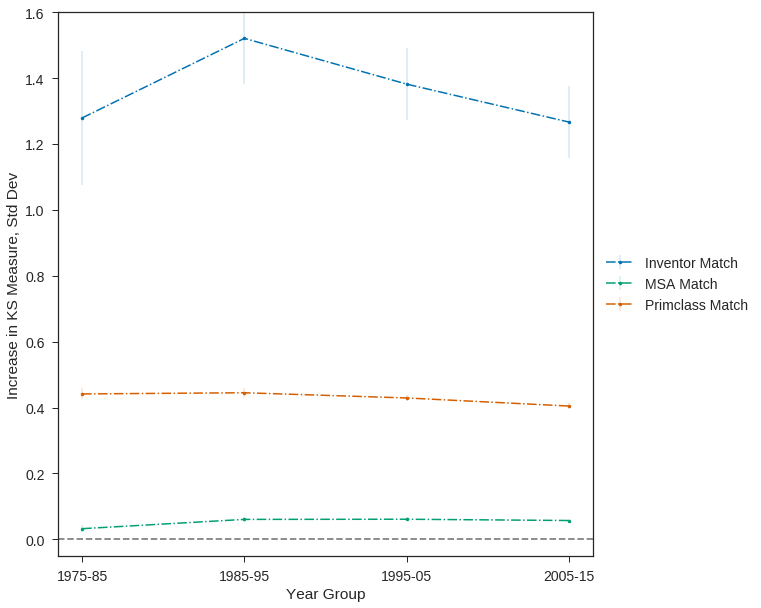

In [137]:
%matplotlib inline
sns.set(font_scale=1.4)
sns.set_style("ticks")
plt.rcParams["font.family"] = "Liberation Sans"
plt.rcParams.update({'font.size': 14})
plt.style.use('seaborn-muted')

d2 = rcl.groupby("id")
spal = sns.color_palette("colorblind", 10).as_hex()
# spal = sns.choose_colorbrewer_palette("qualitative")
# spal = sns.color_palette("Paired", 4).as_hex()
cpal = dict(zip(d2.groups.keys(),spal))
key_order = list(d2.groups.keys())
x_col = "Year Group"
y_col = "Local Est"
y_err="Err Bar"
y_min = -0.05
y_max = 1.6

fig, ax = plt.subplots(figsize=(12,10))
for n in key_order:
    ax.errorbar(x = x_col, y = y_col, yerr = y_err, errorevery=1, fmt=".-", ls="-.",
                elinewidth = 0.25, 
                    linewidth = 1.5, color = cpal[n], label = n, data = d2.get_group(n).copy())
    
# Horizontal line
ax.axhline(y=0, color='grey', linestyle='--')

ax.legend()
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_title("Effect of Other Match Variables on Patent Similarity")

ax.set_xlabel(x_col)
ax.set_ylabel("Increase in KS Measure, Std Dev")
ax.set_ylim(y_min, y_max)

plt.savefig("DataStore/2018-10/ResultsGraphs/naics_other_est.png")
plt.show()

In [138]:
rr["Model"].unique()

array(['Perc Match Targ MSA, Year FE', 'Perc Match Targ MSA, PC FE',
       'N Perc Match Targ MSA, Year FE', 'N Perc Match Targ MSA, PC FE',
       'Sim LDAVecs Match Targ MSA, Year FE',
       'Sim LDAVecs Match Targ MSA, PC FE',
       'N Sim LDAVecs Match Targ MSA, Year FE',
       'N Sim LDAVecs Match Targ MSA, PC FE',
       'Sim DocVecs Match Targ MSA, Year FE',
       'Sim DocVecs Match Targ MSA, PC FE',
       'N Sim DocVecs Match Targ MSA, Year FE',
       'N Sim DocVecs Match Targ MSA, PC FE',
       'Sim LDAVecs - 10 yrs, Year FE', 'Sim LDAVecs - 10 yrs, PC FE',
       'N Sim LDAVecs - 10 yrs, Year FE', 'N Sim LDAVecs - 10 yrs, PC FE',
       'Sim DocVecs - 10 yrs, Year FE', 'Sim DocVecs - 10 yrs, PC FE',
       'N DocVecs - 10 yrs, Year FE', 'N DocVecs - 10 yrs, PC FE',
       'No FE', 'PC FE', 'Inv FE', 'Lawyer FE', 'All FE', 'Inv M',
       'Inv M-PC FE', 'Lawyer M', 'Lawyer M-PC FE', 'CC M', 'CC M-PC FE',
       'PC M', 'PC M-PC FE', 'N No FE', 'N PC FE', 'N Inv FE',
  

In [142]:
# Reshape wide
rcw = pd.DataFrame()
for ind in rc.loc[(rc["index"] == "C(inv_msa_match)[T.True]")].index:
    r2 = pd.DataFrame()
    r2["Year Group"] = ["1975-85", "1985-95", "1995-05", "2005-15"]
    r2["Local Est"] = rc.loc[ind, ["1975-85", "1985-95", "1995-05", "2005-15"]].tolist()
    se = rc.loc[ind+1, ["1975-85", "1985-95", "1995-05", "2005-15"]].values
    r2["Err Bar"] = se*1.96
    r2["id"] = rc.loc[ind, "id"]
    rcw = rcw.append(r2, ignore_index=True)

Local Est                           Err Bar            \
Year Group        1975-85 1985-95 1995-05 2005-15   1975-85   1985-95   
id                                                                      
Inventor Match     1.2789  1.5206  1.3817  1.2664  0.204232  0.139748   
MSA Match          0.0323  0.0605  0.0610  0.0571  0.010388  0.008428   
Primclass Match    0.4413  0.4449  0.4291  0.4045   0.01666  0.012936   

                                     
Year Group        1995-05   2005-15  
id                                   
Inventor Match   0.109564  0.110348  
MSA Match        0.006664   0.00588  
Primclass Match    0.0098  0.008232

In [152]:
rc = rr.loc[rr["id"].isin(rm_n)]
rc2 = rc.loc[rc["index"].apply(lambda x: "[T.True]" in x)]
rc2 = rc2[["index", "1975-85", "1985-95", "1995-05", "2005-15", ]]
rc2["index"] = ["$I(MSA\,Match)$", "S.E.", "$I(Inv\,Match)$", "S.E.", "$I(Primclass\,Match)$", "S.E."]
print(rc2.to_latex(index=False, escape=True, column_format = "lcccc"))

\begin{tabular}{lcccc}
\toprule
                 index &    1975-85 &    1985-95 &    1995-05 &    2005-15 \\
\midrule
       \$I(MSA\textbackslash,Match)\$ &  0.0323*** &  0.0605*** &  0.0610*** &  0.0571*** \\
                  S.E. &   (0.0053) &   (0.0043) &   (0.0034) &   (0.0030) \\
       \$I(Inv\textbackslash,Match)\$ &  1.2789*** &  1.5206*** &  1.3817*** &  1.2664*** \\
                  S.E. &   (0.1042) &   (0.0713) &   (0.0559) &   (0.0563) \\
 \$I(Primclass\textbackslash,Match)\$ &  0.4413*** &  0.4449*** &  0.4291*** &  0.4045*** \\
                  S.E. &   (0.0085) &   (0.0066) &   (0.0050) &   (0.0042) \\
\bottomrule
\end{tabular}

